In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime
import random

Common unit measures:
* Time: seconds
* Data: gigabytes

In [2]:
# NUMERICAL VALUES

# C: capacity of each link (in Gbit/s -> GB/s)
C = 10 / 8

# tau: time to move between two nodes (in microseconds -> seconds)
tau = 5 / 1000000

# L_f: size of input data (in TB -> GB)
L_f = 4 * 1000

# L_o: size of output data (in TB -> GB)
L_o = 4 * 1000

# E_X: expected value of X, the variable amount of time of the computational job (in hours -> seconds)
E_X = 8 * 3600

# T_0: fixed setup time (in seconds)
T_0 = 30

# xi: coefficient for average server time in job running cost calculation
xi = 0.1

# f: fracion of overhead of data given by TCP
f = 48 / 1500

# n: number of ports per switch
n = 64

# N_max: max number of parallel tasks
N_max = 10000

Work pipeline for no parallelism:
* Data arrives at server A
* A starts computation
* A ends computation and the response is available

$E[R] = T_0 + E[X] = 30 + 8 * 3.600 = 28.830$ seconds

$S = E[R] + \xi E[\Theta] = T_0 + E[X] + \xi (T_0 + E[X]) = (1 + \xi) * (T_0 + E[X]) = 1.1 * (28.830) = 31.713$ seconds


In [3]:
# E_R_local: mean response time for local computation (in seconds)
E_R_local = T_0 + E_X

# S_local: job running cost for local computation
S_local = int(E_R_local + xi * E_R_local)

Work pipeline with parallelism:
* "Build network"
* Get distances of nodes
* Data arrives at server A
* Data get sent to subservers (consider overhead | consider different "phases"?)
* Get computation time of each subserver
* Get data produced to each subserver
* Get network delay time for each subserver (consider overhead)
* Get time of slowest subserver

E[R] = E[slowest subserver work]

Each subserver work is divided into:

* Recieving data: every subserver recieves the same amount of data and the throughput depends on the RTT that depends on the distance.
* Computing data: depends on the random variable of the computation time
* Sending data: depends on the random variable of the amount of data to be sent

In [4]:
def get_fat_tree_distances(N):
    same_edge_n_servers = (n // 2) - 1
    same_edge_distance = 2

    same_pod_n_servers = (n**2) // 4 - same_edge_n_servers - 1
    same_pod_distance = 4

    inter_pod_n_servers = (n**3) // 4 - same_pod_n_servers - same_edge_n_servers - 1
    inter_pod_distance = 6

    if(N <= same_edge_n_servers):
        return np.full(N, same_edge_distance)
    else:
        distances_array = np.full(same_edge_n_servers, same_edge_distance)

    if(N <= same_pod_n_servers + same_edge_n_servers):
        return np.concatenate((distances_array, np.full(N - same_edge_n_servers, same_pod_distance)), axis=None)
    else:
        distances_array = np.concatenate((distances_array, np.full(same_pod_n_servers, same_pod_distance)), axis=None)

    if(N <= inter_pod_n_servers + same_pod_n_servers + same_edge_n_servers):
        return np.concatenate((distances_array, np.full(N - same_edge_n_servers - same_pod_n_servers, inter_pod_distance)), axis=None)
    else:
        raise ValueError("N is too large.")
    
def get_fat_tree_rtts(N):
    distances_array = get_fat_tree_distances(N)
    rtts_array = 2 * tau * distances_array

    return rtts_array

def get_fat_tree_throughputs(N):
    rtts_array = get_fat_tree_rtts(N)
    throughputs_array = C * (1 / rtts_array) / (1 / rtts_array).sum()

    return throughputs_array

In [156]:
get_fat_tree_distances(10000)

array([2, 2, 2, ..., 6, 6, 6])

In [21]:
get_fat_tree_throughputs(100)

array([0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.01908397, 0.01908397, 0.01908397, 0.01908397,
       0.01908397, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954198,
       0.00954198, 0.00954198, 0.00954198, 0.00954198, 0.00954

Each subserver has a variable work time of $X_i$ distribuited as a negative exponential random variable.

$E[X_i] = E[X] / N = 1 / \lambda$

$\lambda = N / E[X]$

$X_i \sim Exp(N / E[X])$

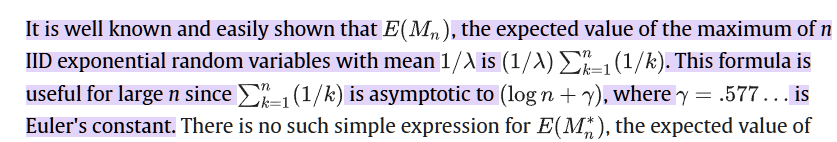

In [5]:
def get_mean_slowest_time(N):
    k = np.arange(1, N + 1)
    lam = N / E_X

    result = np.sum(1 / k)
    result *= (1 / lam)

    return result

# approximation is not required as the calculation is already fast enough
def get_mean_slowest_time_approx(N):
    lam = N / E_X
    return (1 / lam) * (np.log(N) + np.euler_gamma)

In [6]:
def get_times_with_simulation(N):
    E_R_iterations = np.array([])
    S_iterations = np.array([])

    for i in range(n_iterations):
        # initialize throughputs
        throughputs = get_fat_tree_throughputs(N)

        # initialize times
        times = np.full(N, 0, dtype = 'float64')

        # add recieving data time (+ overhead)
        input_amount = (L_f / N) * (1 + f)
        times += input_amount / throughputs

        # add computation time (+ setup time)
        scale = E_X / N
        computation_times = T_0 + np.random.exponential(scale, (N, ))
        times += computation_times

        # add sending data time (+ overhead)
        output_amount = (np.random.uniform(low = 0, high = 2 * L_o / N)) * (1 + f)
        times += output_amount / throughputs

        # compute metrics
        E_R = np.max(times)
        E_R_iterations = np.append(E_R_iterations, E_R)

        S = E_R + xi * np.sum(computation_times)
        S_iterations = np.append(S_iterations, S)

    return np.mean(E_R_iterations), np.mean(S_iterations)

In [161]:
n_iterations = 1000

def simulation_iteration(i, N):
    # initialize throughputs
    throughputs = get_fat_tree_throughputs(N)

    # initialize times
    times = np.full(N, 0, dtype = 'float64')

    # add recieving data time (+ overhead)
    input_amount = (L_f / N) * (1 + f)
    times += input_amount / throughputs

    # add computation time (+ setup time)
    scale = E_X / N
    computation_times = T_0 + np.random.exponential(scale, (N, ))
    times += computation_times

    # add sending data time (+ overhead)
    output_amount = (np.random.uniform(low = 0, high = 2 * L_o / N, size = (N, ))) * (1 + f)
    times += output_amount / throughputs

    # compute metrics
    E_R = np.max(times)
    S = E_R + xi * np.sum(computation_times)

    return E_R, S

simulation_iteration_v = np.vectorize(simulation_iteration)

def get_times_with_simulation(N):
    i = range(1, n_iterations)
    E_R_iterations, S_iterations = simulation_iteration_v(i, N)

    return np.mean(E_R_iterations), np.mean(S_iterations)

In [162]:
get_times_v = np.vectorize(get_times_with_simulation)

N_list = np.concatenate((np.arange(1, 127, step = 1), np.arange(127, 1024, step = 8), np.arange(1024, 1200), np.arange(1200, 10128, step = 128)))

E_R_array, S_array = get_times_v(N_list)

# normalize

E_R_array /= E_R_local
S_array /= S_local

In [52]:
def save_arrays(E_R_array, S_array):
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    np.save(f"E_R_array_{timestamp}.npy", E_R_array)
    np.save(f"S_array{timestamp}.npy", S_array)

save_arrays(E_R_array, S_array)

In [164]:
np.min(E_R_array)

0.35697946157189836

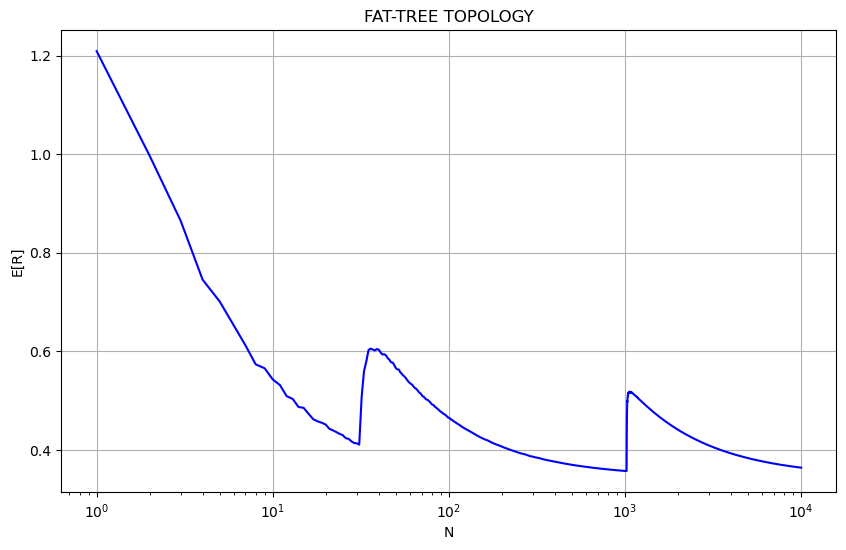

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(N_list, E_R_array, color='blue')
plt.xlabel('N')
plt.ylabel('E[R]')
plt.title('FAT-TREE TOPOLOGY')
plt.grid(True)
plt.xscale('log')
plt.show()

In [ ]:
def get_times_deterministic(N):
    for i in range(n_iterations):
        # initialize throughputs
        throughputs = get_fat_tree_throughputs(N)

        # initialize times
        times = np.full(N, 0, dtype = 'float64')

        # add recieving data time (+ overhead)
        input_amount = (L_f / N) * (1 + f)
        times += input_amount / throughputs

        # add computation time (+ setup time)
        scale = E_X / N
        computation_times = T_0 + np.random.exponential(scale, (N, ))
        times += computation_times

        # add sending data time (+ overhead)
        output_amount = (L_o / N) * (1 + f)
        times += output_amount / throughputs

        # compute metrics
        E_R = np.max(times)
        S = E_R + xi * np.sum(computation_times)

    return E_R, S

In [ ]:
def save_arrays(E_R_array, S_array):
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    np.save(f"E_R_array_{timestamp}.npy", E_R_array)
    np.save(f"S_array{timestamp}.npy", S_array)

save_arrays(E_R_array, S_array)

In [158]:
def load_arrays(timestamp):
    # Load array1
    E_R_array = np.load(f"E_R_array_{timestamp}.npy")

    # Load array2
    S_array = np.load(f"S_array_{timestamp}.npy")

    return E_R_array, S_array

# Example usage
E_R_array, S_array = load_arrays("1m")

In [160]:
np.min(E_R_array)

0.24373805813885116

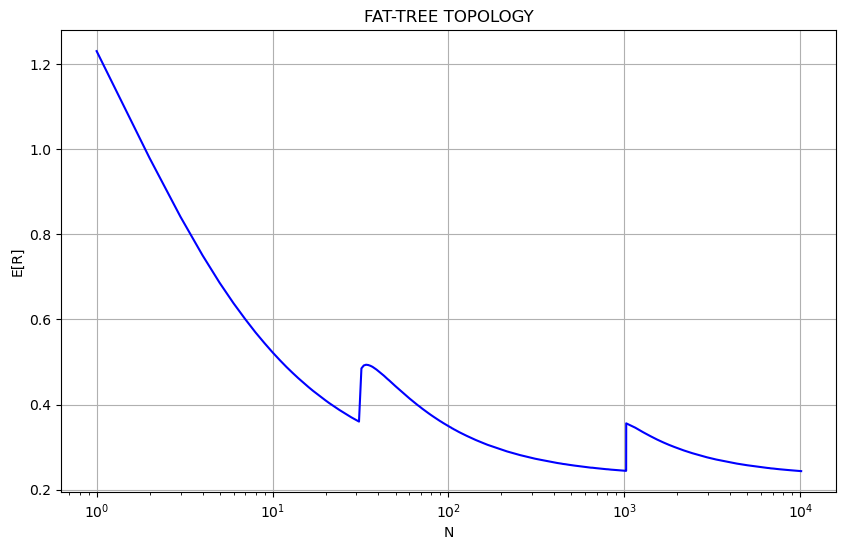

In [159]:
N_list = np.concatenate((np.arange(1, 127, step = 1), np.arange(127, 1024, step = 8), np.arange(1024, 10113, step = 128)))

plt.figure(figsize=(10, 6))
plt.plot(N_list, E_R_array, color='blue')
plt.xlabel('N')
plt.ylabel('E[R]')
plt.title('FAT-TREE TOPOLOGY')
plt.grid(True)
plt.xscale('log')
plt.show()

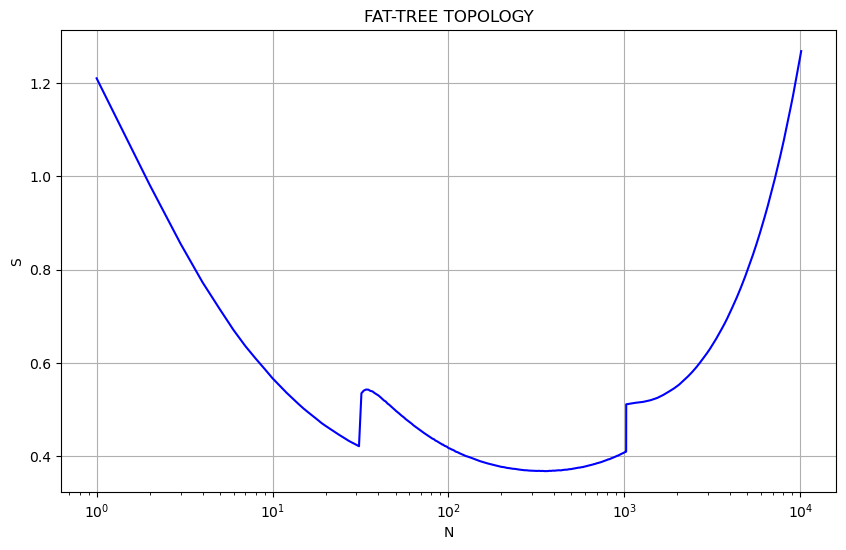

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(N_list, S_array, color='blue')
plt.xlabel('N')
plt.ylabel('S')
plt.title('FAT-TREE TOPOLOGY')
plt.grid(True)
plt.xscale('log')
plt.show()

In [24]:
def get_jellyfish_distances_deterministic(N):
    # the first servers we get are those in the same rack as the main server
    # there are 31 servers beside the main one
    # distance is 2 since we go from server to switch and back to server
    same_rack_n_servers = (n // 2) - 1
    same_rack_distance = 2

    # main server's switch has 32 links to other swithces
    # since there are no loops all those new switches are 'unexplored'
    # distance for those servers is 4
    near_rack_n_servers = (n // 2)**2
    near_rack_distance = 4

    # next things become deterministic, the 32 switches could be linked to new switches
    # or to the same we have already seen
    # there is the probability that not every new server will be available at distance 3

    if(N <= same_rack_n_servers):
        return np.full(N, same_rack_distance)
    else:
        distances_array = np.full(same_rack_n_servers, same_rack_distance)

    if(N <= near_rack_n_servers + same_rack_n_servers):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers, near_rack_distance)), axis=None)
    else:
        distances_array = np.concatenate((distances_array, np.full(near_rack_n_servers, near_rack_distance)), axis=None)

    if(N <= N**3 // 4):
        # execute simulation

        missing_switches = np.ceil((N - near_rack_n_servers - near_rack_n_servers) / 32)
        available_links_current_level = 1024
        available_links_new_level = 0
        explored_switches = 33
        total_switches = 2048
        current_distance = 6

        while missing_switches != 0:
            repetition = np.random.binomial(n = 1, p = explored_switches / total_switches)

            if(not repetition):
                missing_switches -= 1
                available_links_current_level -= 1
                explored_switches += 1
                available_links_new_level += 32

                distances_array = np.concatenate((distances_array, current_distance), axis=None)
            
            else:
                available_links_current_level -= 1
            
            if(available_links_current_level == 0):
                available_links_current_level = available_links_new_level
                available_links_new_level = 0
                current_distance += 2


        return distances_array
    else:
        raise ValueError("N is too large.")

In [19]:
def get_fat_tree_rtts(N):
    distances_array = get_fat_tree_distances(N)
    rtts_array = 2 * tau * distances_array

    return rtts_array

def get_fat_tree_throughputs(N):
    rtts_array = get_fat_tree_rtts(N)
    throughputs_array = C * (1 / rtts_array) / (1 / rtts_array).sum()

    return throughputs_array

---

Jellyfish's original paper (https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final82.pdf) states that:

"In the simplest case, which we consider by default throughout this paper, every switch has the same number of ports and servers: ∀i, k = ki and r = ri.
With N racks, the network supports N(k − r) servers. In this case, the network is a random regular graph, which we denote as RRG(N, k, r)."

"Formally, RRGs are sampled uniformly from the space of all r-regular graphs. This is a complex problem in graph theory [29]; however, a simple procedure produces “sufficiently uniform” random graphs which empirically have the desired performance properties."

In [103]:
def get_jellyfish_distances(N):
    # first try deterministically

    # the first servers we get are those in the same rack as the main server
    # there are 31 servers beside the main one
    # distance is 2 since we go from server to switch and back to server
    same_rack_n_servers = (n // 2) - 1
    same_rack_distance = 2

    # main server's switch has 32 links to other swithces
    # since there are no loops all those new switches are 'unexplored'
    # distance for those servers is 4
    near_rack_n_servers = (n // 2)**2
    near_rack_distance = 4

    # next things become deterministic, the 32 switches could be linked to new switches
    # or to the same we have already seen
    # there is the probability that not every new server will be available at distance 3

    if(N <= same_rack_n_servers):
        return np.full(N, same_rack_distance)
    else:
        distances_array = np.full(same_rack_n_servers, same_rack_distance)

    if(N <= near_rack_n_servers + same_rack_n_servers):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers, near_rack_distance)), axis=None)
    
    # else use simulation

    degree_nodes = 32 # since every switch has 32 ports to connect to other switches
    n_nodes = 2048 # since we want n^3 // 4 = 65536 servers and each switch has 32 server -> 65536 / 32 = 2048

    needed_switches = int(np.ceil((N + 1) / 32))

    # Create Jellyfish graph
    switches_graph = nx.random_regular_graph(d = degree_nodes, n = n_nodes)

    # Select a random node from the graph
    random_node = random.choice(list(switches_graph.nodes()))

    # Calculate distances from the random node to all other nodes
    distances = nx.shortest_path_length(switches_graph, source=random_node)

    # Sort the distances and get the closest
    sorted_distances = sorted(distances.values())

    switches_distances = np.array(sorted_distances[:needed_switches])

    # convert switch distances into server distances
    # add 2 to count for link between source server and switch
    # and between destination and switch    
    # for every switch add 32 servers except for the first one
    # which will only have 31 and the last one that will have as
    # enough to complete the request

    server_distances = np.repeat(switches_distances + 2, 32)[1 : N + 1]

    return server_distances

In [148]:
def get_jellyfish_rtts(N):
    distances_array = get_jellyfish_distances_deterministic(N)
    rtts_array = 2 * tau * distances_array

    return rtts_array

def get_jellyfish_throughputs(N):
    rtts_array = get_jellyfish_rtts(N)
    throughputs_array = C * (1 / rtts_array) / (1 / rtts_array).sum()

    return throughputs_array

In [165]:
n_iterations = 100000

def simulation_iteration_jellyfish(i, N):
    # initialize throughputs
    throughputs = get_jellyfish_throughputs(N)

    # initialize times
    times = np.full(N, 0, dtype = 'float64')

    # add recieving data time (+ overhead)
    input_amount = (L_f / N) * (1 + f)
    times += input_amount / throughputs

    # add computation time (+ setup time)
    scale = E_X / N
    computation_times = T_0 + np.random.exponential(scale, (N, ))
    times += computation_times

    # add sending data time (+ overhead)
    output_amount = (np.random.uniform(low = 0, high = 2 * L_o / N, size = (N, ))) * (1 + f)
    times += output_amount / throughputs

    # compute metrics
    E_R = np.max(times)
    S = E_R + xi * np.sum(computation_times)

    return E_R, S

simulation_iteration_jellyfish_v = np.vectorize(simulation_iteration_jellyfish)

def get_times_with_simulation_jellyfish(N):
    i = range(1, n_iterations)
    E_R_iterations, S_iterations = simulation_iteration_jellyfish_v(i, N)

    return np.mean(E_R_iterations), np.mean(S_iterations)

get_times_jellyfish_v = np.vectorize(get_times_with_simulation_jellyfish)

In [166]:
N_list = np.concatenate((np.arange(1, 127, step = 1), np.arange(127, 1024, step = 8), np.arange(1024, 1200), np.arange(1200, 10128, step = 128)))

E_R_array, S_array = get_times_jellyfish_v(N_list)

# normalize

E_R_array /= E_R_local
S_array /= S_local

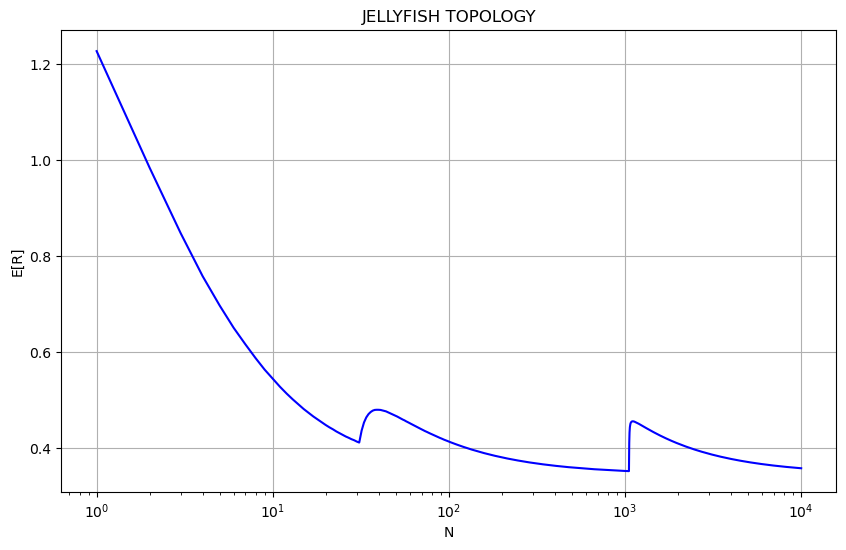

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(N_list, E_R_array, color='blue')
plt.xlabel('N')
plt.ylabel('E[R]')
plt.title('JELLYFISH TOPOLOGY')
plt.grid(True)
plt.xscale('log')
plt.show()

In [168]:
save_arrays(E_R_array, S_array)

In [155]:
np.min(E_R_array)

0.3516031493120687

In [ ]:
%%timeit

get_fat_tree_distances(10000)

In [140]:
def get_jellyfish_distances(N):
    degree_nodes = 32 # since every switch has 32 ports to connect to other switches
    n_nodes = 2048 # since we want n^3 // 4 = 65536 servers and each switch has 32 server -> 65536 / 32 = 2048

    needed_switches = int(np.ceil((N + 1) / 32))

    # Create Jellyfish graph
    switches_graph = nx.random_regular_graph(d = degree_nodes, n = n_nodes)

    # Select a random node from the graph
    random_node = random.choice(list(switches_graph.nodes()))

    # Calculate distances from the random node to all other nodes
    distances = nx.shortest_path_length(switches_graph, source=random_node)

    # Sort the distances and get the closest
    sorted_distances = sorted(distances.values())

    switches_distances = np.array(sorted_distances[:needed_switches])

    # convert switch distances into server distances
    # add 2 to count for link between source server and switch
    # and between destination and switch    
    # for every switch add 32 servers except for the first one
    # which will only have 31 and the last one that will have as
    # enough to complete the request

    server_distances = np.repeat(switches_distances + 2, 32)[1 : N + 1]
    return server_distances

    # return np.max(server_distances)

In [127]:
get_jellyfish_distances(10000)

4

In [132]:
data = []

for i in range(1, 10000):
    data.append(get_jellyfish_distances(10000))

In [133]:
np.min(data)

4

In [134]:
np.max(data)

4

In [136]:
len(data)

9999

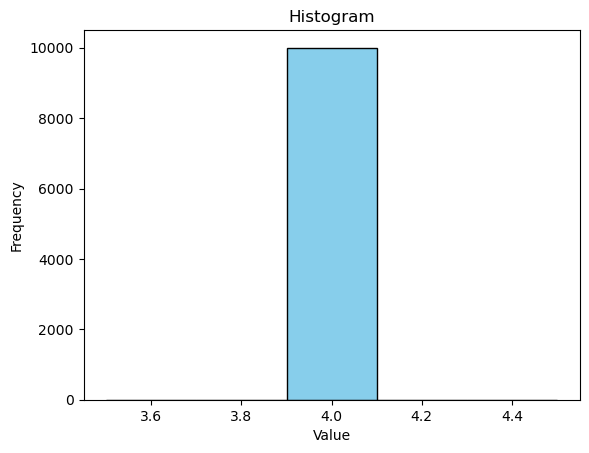

In [137]:
# Plot histogram
plt.hist(data, bins=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show plot
plt.show()

In [151]:
def get_jellyfish_distances_deterministic(N):
    # the first servers we get are those in the same rack as the main server
    # there are 31 servers beside the main one
    # distance is 2 since we go from server to switch and back to server
    same_rack_n_servers = (n // 2) - 1
    same_rack_distance = 2

    # main server's switch has 32 links to other swithces
    # since there are no loops all those new switches are 'unexplored'
    # distance for those servers is 4
    near_rack_n_servers = (n // 2)**2
    near_rack_distance = 3

    far_rack_distance = 4

    if(N <= same_rack_n_servers):
        return np.full(N, same_rack_distance)
    else:
        distances_array = np.full(same_rack_n_servers, same_rack_distance)

    if(N <= near_rack_n_servers + same_rack_n_servers):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers, near_rack_distance)), axis=None)
    else:
        distances_array = np.concatenate((distances_array, np.full(near_rack_n_servers, near_rack_distance)), axis=None)

    if(N <= n**3 // 4):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers - near_rack_n_servers, far_rack_distance)), axis=None)
    else:
        raise ValueError("N is too large.")

In [152]:
get_jellyfish_distances_deterministic(10000)

array([2, 2, 2, ..., 4, 4, 4])